In [1]:
%matplotlib inline

import os
import glob
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from labellines import labelLine, labelLines

# Plot configurations
sns.set_context("notebook", font_scale=1.2, rc={"lines.linewidth": 1.2})
sns.set_style("darkgrid")
custom_style = {
            'grid.color': '0.8',
            'grid.linestyle': '--',
            'grid.linewidth': 0.5,
}
sns.set_style(custom_style)

In [2]:
# Run parameters

DATA_DIR = "csse_covid_19_data/csse_covid_19_daily_reports/"
MIN_DATE = "2020-03-10"
MAX_DATE = "2020-03-23"
INCLUDE_LIST = ["North Carolina", "South Carolina", "Georgia", "Virginia"]
EXCLUDE_LIST = []
STATE_LIMIT = 0

In [3]:
# Data sample pre-3/22

pd.read_csv(DATA_DIR + "03-21-2020.csv").head()

,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered,Latitude,Longitude
0,Hubei,China,2020-03-21T10:13:08,67800,3139,58946,30.9756,112.2707
1,NaN,Italy,2020-03-21T17:43:03,53578,4825,6072,41.8719,12.5674
2,NaN,Spain,2020-03-21T13:13:30,25374,1375,2125,40.4637,-3.7492
3,NaN,Germany,2020-03-21T20:43:02,22213,84,233,51.1657,10.4515
4,NaN,Iran,2020-03-21T11:13:12,20610,1556,7635,32.4279,53.6880


In [4]:
# Data sample post-3/22

pd.read_csv(DATA_DIR + "03-22-2020.csv").head()

,FIPS,Admin2,Province_State,Country_Region,Last_Update,Lat,Long_,Confirmed,Deaths,Recovered,Active,Combined_Key
0,36061.0,New York City,New York,US,3/22/20 23:45,40.767273,-73.971526,9654,63,0,0,"New York City, New York, US"
1,36059.0,Nassau,New York,US,3/22/20 23:45,40.740665,-73.589419,1900,4,0,0,"Nassau, New York, US"
2,36119.0,Westchester,New York,US,3/22/20 23:45,41.162784,-73.757417,1873,0,0,0,"Westchester, New York, US"
3,36103.0,Suffolk,New York,US,3/22/20 23:45,40.883201,-72.801217,1034,9,0,0,"Suffolk, New York, US"
4,36087.0,Rockland,New York,US,3/22/20 23:45,41.150279,-74.025605,455,1,0,0,"Rockland, New York, US"


In [5]:
def build_aggregate_df():

    agg_df = None

    for fn in glob.glob(DATA_DIR + "*.csv"):
        df = pd.read_csv(fn)
        df["Date"] = fn.split("/")[-1].split(".csv")[0]
        df.rename(columns={
            "Country/Region": "Country_Region", 
            "Province/State": "Province_State",
            "Lat": "Latitude",
            "Long_": "Longitude",
            "Last Update": "Last_Update"
        }, inplace=True)
        if agg_df is None:
            agg_df = df
        else:
            agg_df = agg_df.append(df, ignore_index=True)

    agg_df["Date"] = pd.to_datetime(agg_df["Date"])

    print("Num Rows:", agg_df.shape[0])
    print("Total Dates:", agg_df["Date"].unique().shape[0])
    print("Min Date:", agg_df["Date"].min())
    print("Max Date:", agg_df["Date"].max())
    
    return agg_df

agg_df = build_aggregate_df()

agg_df.head()

Num Rows: 21286
Total Dates: 64
Min Date: 2020-01-22 00:00:00
Max Date: 2020-03-25 00:00:00


,FIPS,Admin2,Province_State,Country_Region,Last_Update,Latitude,Longitude,Confirmed,Deaths,Recovered,Active,Combined_Key,Date
0,45001.0,Abbeville,South Carolina,US,2020-03-23 23:19:34,34.223334,-82.461707,1.0,0.0,0.0,0.0,"Abbeville, South Carolina, US",2020-03-23
1,22001.0,Acadia,Louisiana,US,2020-03-23 23:19:34,30.295065,-92.414197,1.0,0.0,0.0,0.0,"Acadia, Louisiana, US",2020-03-23
2,51001.0,Accomack,Virginia,US,2020-03-23 23:19:34,37.767072,-75.632346,1.0,0.0,0.0,0.0,"Accomack, Virginia, US",2020-03-23
3,16001.0,Ada,Idaho,US,2020-03-23 23:19:34,43.452658,-116.241552,13.0,0.0,0.0,0.0,"Ada, Idaho, US",2020-03-23
4,19001.0,Adair,Iowa,US,2020-03-23 23:19:34,41.330756,-94.471059,1.0,0.0,0.0,0.0,"Adair, Iowa, US",2020-03-23


In [6]:
def build_state_df(agg_df):
    # Filter for US states only
    state_df = agg_df[agg_df["Country_Region"]=="US"]

    print("Num Rows:", state_df.shape[0])
    print("Total Dates:", state_df["Date"].unique().shape[0])
    print("Min Date:", state_df["Date"].min())
    print("Max Date:", state_df["Date"].max())
    state_df = state_df[["Date", "Province_State", "Confirmed"]]
    return state_df

state_df = build_state_df(agg_df)

state_df.head()

Num Rows: 14272
Total Dates: 64
Min Date: 2020-01-22 00:00:00
Max Date: 2020-03-25 00:00:00


,Date,Province_State,Confirmed
0,2020-03-23,South Carolina,1.0
1,2020-03-23,Louisiana,1.0
2,2020-03-23,Virginia,1.0
3,2020-03-23,Idaho,13.0
4,2020-03-23,Iowa,1.0


In [7]:
def filter_states(state_df):
    
    # Limit date range
    state_df = state_df[state_df["Date"].between(MIN_DATE, MAX_DATE)]

    # Limit to top n states
    top_n = (
        state_df[state_df.Date==MAX_DATE]
        .groupby("Province_State")
        .sum()
        .sort_values("Confirmed", ascending=False)
    )[:STATE_LIMIT].index.to_list()

    top_n.extend(INCLUDE_LIST) 
    for state in EXCLUDE_LIST:
        top_n.remove(state)

    print("Filtered states:\n", top_n)
    state_df = state_df[state_df.Province_State.isin(top_n)]
    return state_df
    
state_df = filter_states(state_df)

state_df.head()

Filtered states:
 ['North Carolina', 'South Carolina', 'Georgia', 'Virginia']


,Date,Province_State,Confirmed
0,2020-03-23,South Carolina,1.0
2,2020-03-23,Virginia,1.0
21,2020-03-23,South Carolina,1.0
24,2020-03-23,North Carolina,2.0
29,2020-03-23,Virginia,2.0


In [8]:
def build_cumulative_df(state_df):

    cum_df = state_df.groupby(by=["Date", "Province_State"]).sum()

    cum_df = cum_df.unstack()
    cum_df.columns = cum_df.columns.droplevel()
    cum_df.reset_index(level=0, inplace=True)
    
    return cum_df
    
cum_df = build_cumulative_df(state_df)

cum_df.head()

Province_State,Date,Georgia,North Carolina,South Carolina,Virginia
0,2020-03-10,17.0,7.0,7.0,7.0
1,2020-03-11,23.0,7.0,10.0,9.0
2,2020-03-12,31.0,15.0,12.0,17.0
3,2020-03-13,42.0,17.0,13.0,30.0
4,2020-03-14,66.0,24.0,19.0,41.0


In [9]:
def legend_positions(df, y):
    """ Calculate position of labels to the right in plot... """
    positions = {}
    for column in y:    
        positions[column] = df[column].values[-1] - 0.5    

    def push():
        """
        ...by putting them to the last y value and
        pushing until no overlap
        """
        collisions = 0
        for column1, value1 in positions.items():
            for column2, value2 in positions.items():
                if column1 != column2:
                    dist = abs(value1-value2)
                    if dist < 2.5:
                        collisions += 1
                        if value1 < value2:
                            positions[column1] -= .1
                            positions[column2] += .1
                        else:
                            positions[column1] += .1
                            positions[column2] -= .1
                        return True
    while True:
        pushed = push()
        if not pushed:
            break

    return positions

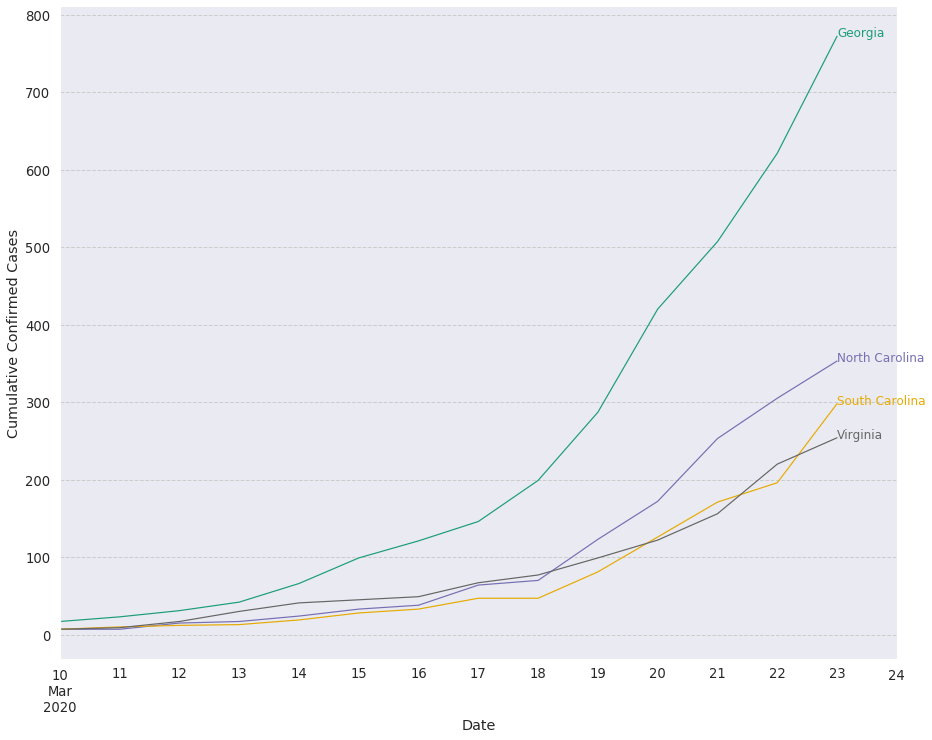

In [10]:
def plot_case_growth(df):
    plot_df = df.copy()
    x = 'Date'
    y = plot_df.columns.tolist()[1:]
    
    f, ax = plt.subplots(figsize=(15,12))        
    cmap = plt.cm.get_cmap('Dark2', len(y))
    
    positions = legend_positions(plot_df, y)
    
    for i, (column, position) in enumerate(positions.items()):

        # Get a color
        color = cmap(float(i)/len(positions))
        # Plot each line separatly so we can be explicit about color
        ax = plot_df.plot(x=x, y=column, legend=False, ax=ax, color=color)

        # Add the text to the right
        plt.text(
            plot_df[x][plot_df[column].last_valid_index()],
            position, column, fontsize=12,
            color=color # Same color as line
        )
    ax.set_ylabel('Cumulative Confirmed Cases')
    ax.set(xlim=(MIN_DATE, plot_df.Date.max() + pd.DateOffset(days=1)))

    sns.despine()
    
plot_case_growth(cum_df)